# ML - TME 4 : Introduction à Pytorch (II)


Nicolas Baskiotis (nicolas.baskiotis@sorbonne-universite.fr)  -- MLIA/ISIR, Sorbonne Université


## Préambule

Dans cette deuxième partie, nous verrons les modules - brique de base de PyTorch - l'utilisation du GPU.

Il se conclut sur une partie expérimentale sur MNIST.


In [1]:
import torch
print("La version de torch est : ",torch.__version__)
print("Le calcul GPU est disponible ? ", torch.cuda.is_available())
from torch import nn
import numpy as np
import sklearn
import matplotlib.pyplot as plt
#%matplotlib widget

La version de torch est :  2.1.1+cu121
Le calcul GPU est disponible ?  False


## Module
Dans le framework pytorch (et dans la plupart des frameworks analogues), <a href="https://pytorch.org/docs/stable/nn.html">le module</a> est la brique de base qui permet de construire un réseau de neurones.Tous les modules se trouvent dans **torch.nn**. Un module permet de représenter en particulier :
* une couche du réseau (linéaire : **nn.Linear**, convolution : **nn.convXd**, ...)
* une fonction d'activation (tanh : **nn.Tanh**, sigmoïde : **nn.Sigmoid** , ReLu : **nn.ReLU**, ...)
* une fonction de coût (MSE : **nn.MSELoss**, L1 :  **nn.L1Loss**, CrossEntropy binaire: **nn.BCE**, CrossEntropy : **nn.CrossEntropyLoss**, ...)
* mais également des outils de régularisation (BatchNorm : **nn.BatchNorm1d**, Dropout : **nn.Dropout**, ...)
* un ensemble de modules : en termes informatique, un module est un conteneur abstrait qui peut contenir d'autres conteneurs) : plusieurs modules peuvent être mis ensemble afin de former un nouveau module plus complexe. Ainsi, **nn.Sequential** permet d'enchaîner des modules, **nn.ModuleList** permet de faire une liste de module, ...

Un objet module comporte une encapsulation qui permet de gérer automatiquement les paramètres à apprendre. Ainsi, lorsque plusieurs modules sont regroupés dans un même conteneur, tous les paramètres des sous-modules sont automatiquement considérés comme des paramètres du conteneur. Un module est muni :
* d'une méthode **forward** qui permet de calculer la sortie du module à partir des entrées
* d'une méthode **backward** qui permet d'effectuer la rétro-propagation (localement).
* d'une méthode **parameters** qui permet d'obtenir tous les paramètres du module.

Ci-dessous un exemple d'utilisation d'un module linéaire.


In [2]:
# Tenseur de 5x10
x = torch.randn(5,10)
## Création d'une couche linéaire de dimension 10->1
net = torch.nn.Linear(10, 1) 
## Passe forward du module 
print("Sortie du réseau", net.forward(x))
## Equivalent : 
print("Sortie du réseau", net(x))

## affiche la liste des paramètres du modèle
print("Paramètres : ", list(net.parameters()))
print("Paramètres et leurs noms : ", list(net.named_parameters()))

## Création d'une fonction de loss aux moindres carrés
mseloss = torch.nn.MSELoss()
## on créé un optimiseur pour le réseau (paramètres w et b)
optim = torch.optim.Adam(params=net.parameters(),lr=1e-3) 
## Juste pour info, ce n'est pas utile, les paramètres sont déjà initialisés.
net.reset_parameters()
## Calcul du coût
l = mseloss(net(x),torch.randn(5,1))
print(f"Le coût est de {l.item()}")

# Passe backward 
optim.zero_grad()
l.backward()
optim.step() 
# Paramètres mis à jour 
print("Paramètres mis à jour : ",list(net.named_parameters()))

Sortie du réseau tensor([[ 0.7422],
        [-0.4952],
        [-0.1637],
        [ 0.8226],
        [-0.7597]], grad_fn=<AddmmBackward0>)
Sortie du réseau tensor([[ 0.7422],
        [-0.4952],
        [-0.1637],
        [ 0.8226],
        [-0.7597]], grad_fn=<AddmmBackward0>)
Paramètres :  [Parameter containing:
tensor([[-0.3065,  0.1210,  0.1388, -0.2362,  0.1852, -0.0366, -0.2237,  0.0094,
          0.0062, -0.2289]], requires_grad=True), Parameter containing:
tensor([-0.2056], requires_grad=True)]
Paramètres et leurs noms :  [('weight', Parameter containing:
tensor([[-0.3065,  0.1210,  0.1388, -0.2362,  0.1852, -0.0366, -0.2237,  0.0094,
          0.0062, -0.2289]], requires_grad=True)), ('bias', Parameter containing:
tensor([-0.2056], requires_grad=True))]


2024-02-13 11:24:58.459916: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-13 11:24:59.874623: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-13 11:25:00.235052: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /Infos/bd/client11/instantclient_11_2:/opt/gurobi801/linux64/lib
2024-02-13 11:25:00.235065: I tensorflow/s

Le coût est de 0.6942968964576721
Paramètres mis à jour :  [('weight', Parameter containing:
tensor([[ 2.9376e-01,  1.8642e-01, -3.4948e-02, -1.1943e-01, -3.0416e-01,
          2.3115e-01,  1.0274e-01,  4.1358e-05, -1.0959e-02,  1.9042e-01]],
       requires_grad=True)), ('bias', Parameter containing:
tensor([0.3106], requires_grad=True))]


## Création d'un réseau de neurones

Avec ces briques élémentaires, il est très facile de définir un réseau de neurones standard :
* soit en utilisant le conteneur **nn.Sequential** qui permet d'enchaîner séquentiellement plusieurs modules, et qui chaîne automatiquement la sortie d'un module à l'entrée du suivant
* soit en définissant à la main un nouveau module en le faisant hérité de la classe **nn.Module**. Dans ce cas, il est nécessaire de coder la méthode **forward** afin d'indiquer le comportement du module.

Ci-dessous un exemple  pour créer un réseau à deux couches linéaires avec une fonction d'activation tanh des deux manières différentes. Vous remarquez qu'il n'y a pas besoin de définir la méthode **backward**, celle-ci est héritée du conteneur abstrait et ne fait qu'appeler séquentiellement en ordre inverse les méthodes **backward** des différents modules. 

In [3]:
EPS = 1e-2
EPOCHS=50

#Création d'un réseau à 1 couche cachée avec le module séquentiel
netSeq = torch.nn.Sequential(torch.nn.Linear(10,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
    
#Même réseau mais à la main
class DeuxCouches(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.un = torch.nn.Linear(10,5)
    self.act = torch.nn.Tanh()
    self.deux = torch.nn.Linear(5,1)
  def forward(self,x):
    return self.deux(self.act(self.un(x)))

netDeuxCouches = DeuxCouches()

print(netSeq)
print(netDeuxCouches)

Sequential(
  (0): Linear(in_features=10, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
)
DeuxCouches(
  (un): Linear(in_features=10, out_features=5, bias=True)
  (act): Tanh()
  (deux): Linear(in_features=5, out_features=1, bias=True)
)



## GPU 
Afin d'utiliser un GPU lors des calculs, il est nécessaire de transférer les données et le modèle sur le GPU par l'intermédiaire de la fonction **to(device)** des tenseurs et des modules.  Il est impossible de faire une opération lorsqu'une partie des tenseurs sont sur GPU et l'autre sur CPU. Il faut que tous les tenseurs et paramètres soient sur le même device ! On doit donc s'assurer que le modèle, les exemples et les labels sont sur GPU pour faire les opérations.

Par ailleurs, on peut connaître le device sur lequel est chargé un tenseur par l'intermédiaire de ```.device``` (mais pas pour un modèle, il faut aller voir les paramètres dans ce cas).

Une manière simple d'utiliser un GPU quand il existe et donc d'avoir un code agnostique est la suivante : 


In [4]:
## Est-ce qu'un GPU est disponible ?
use_cuda = torch.cuda.is_available()
## Si oui, on le définit comme device
device = torch.device("cuda" if use_cuda else "cpu")

## On charge le modèle sur GPU
## A faire avant la déclaration de l'optimiseur, sinon les paramètres optimisés ne seront pas les mêmes! 
netSeq = netSeq.to(device)
# Equivalent à  (opération inplace)
netSeq.to(device)

optim = torch.optim.Adam(params=netSeq.parameters(),lr=EPS)

## Si les paramètres ne sont pas sur le device, erreur !
x = torch.randn(5,10)
try:
    print(netSeq(x))
except Exception as e:
    print(e)

## On transfère les paramètres sur GPU (!! opération non inplace !!)
x = x.to(device)
print("Device du mini-batch : ", x.device)

## Et cette fois-ci, ça marche
print(netSeq(x))

tensor([[-0.1533],
        [-0.1756],
        [ 0.0482],
        [-0.0878],
        [-0.5813]], grad_fn=<AddmmBackward0>)
Device du mini-batch :  cpu
tensor([[-0.1533],
        [-0.1756],
        [ 0.0482],
        [-0.0878],
        [-0.5813]], grad_fn=<AddmmBackward0>)


## Boucle typique d'apprentissage

Ci-dessous la boucle minimaliste typique en PyTorch pour l'apprentissage d'un modèle. N'hesitez pas à la modifier à votre convenance. Assurez vous de bien comprendre ce que fait chaque ligne de ce code.
En particulier, on suppose que chaque modèle passé possède un attribut **name** pour pouvoir le logger dans tensorboard. Cet attribut n'existe pas par défaut, il faut l'ajouter manuellement (rappel : en python, il suffit de faire **net.name="mon réseau"** pour créer un tel attribut...)

In [5]:
def accuracy(yhat,y):
    """ Calcul la précision 
        yhat: soit vecteur de taille N dans le cas binaire avec N proba de la classe 1, soit matrice NxK, K nombre de classes, score de chaque classe pour chaque exemple
        y : vecteur des indexes ground truth
    """
    if len(yhat.size())<2:
        return ((yhat.view(-1)>0.5).int()==y).float().mean()
    return (yhat.argmax(1)==y.view(-1)).float().mean()

In [53]:
TB_PATH = "/tmp/logtb"

def train(model, dataloaders, loss, eps,epochs,acc=True):
    """
    Boucle d'apprentissage d'un modèle
    
        model: modèle à entrainer
        dataloaders: dictionnaire avec : 'train' le dataloader de train, 'val' de validation et 'test' de test
        loss: la fonction de coût à utiliser
        epochs: le nombre d'époque
        acc: calcul de l'accuracy ou non
    """
    ## Création du log tensorboard
    swriter = SummaryWriter(f"{TB_PATH}/{model.name}")
    ## définition de l'optimiseur
    optim = torch.optim.Adam(model.parameters(),eps=eps)
    ## transfert du modèle sur gpu/cpu
    model = model.to(device)
    ## Boucle sur les époques
    loss_list=[]
    acc_list=[]
    for e in range(epochs):
        ## Boucle sur les différentes phases
        for phase in ['train','val','test']:
            if phase not in dataloaders:
                continue
            dl = dataloaders[phase]
            ## Loss cumulative sur les batchs
            cuml = 0.
            ## Accuracy cumulative sur les batchs
            cumacc = 0.
            ## équivalent à with torch.no_grad() if phase != 'train'
            with torch.set_grad_enabled(phase=='train'):
                ## parcours du dataloader
                for bx, by in dl:
                    ## transfert sur gpu/cpu
                    bx,by = bx.to(device), by.to(device)
                    ## calcul des prédictions
                    yhat = model(bx)
                    ## calcul du coût
                    l = loss(yhat,by)
                    ## calcul de la précision et de l'erreur cumulées
                    if acc :
                        cumacc += accuracy(yhat.detach(),by)*len(bx)
                    cuml += l.item()*len(bx)
                    ## Mise à jour des poids
                    if phase=='train':
                        optim.zero_grad()
                        l.backward()
                        optim.step()
            cuml = cuml/len(dl.dataset)
            swriter.add_scalar(f"loss/{phase}",cuml,e)
            loss_list.append(cuml)
            if acc:
                cumacc = cumacc/len(dl.dataset)
                swriter.add_scalar(f"prec/{phase}",cumacc,e)
                acc_list.append(cumacc)
    return loss_list,acc_list

# <font color="green">  Expérimentations </font>

##  Chargement du dataset MNIST
Le code suivant permet de charger MNIST. Changez le chemin du téléchargement pour le mettre dans un endroit où il n'y a pas de problème de quota (par exemple **/temporary** sur la ppti dans les salles avec GPUs ou **/vrac** sur les autres). 
Chaque image est transformé ensuite pour centré/normé les données et applatit en un vecteur de taille **height*width**. 

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
import os
from torch.utils.tensorboard import SummaryWriter
from tensorboard import notebook
from torchvision import datasets, transforms
import pandas as pd

## Pensez à changer le /tmp/mnist à un chemin valable
## une fois le dataset telecharge, mettre download=False !
## Pour le test, train = False
data_train_raw = datasets.MNIST( '/tmp/mnist',train=True, download=True)
data_test_raw =  datasets.MNIST( '/tmp/mnist',train=False, download=True)

data_shape = data_train_raw.data.shape 
height,width = data_shape[1],data_shape[2] # taille de l'image

# On transforme les images en vecteurs de réels
data_train = data_train_raw.data.float().reshape(-1,height*width)
y_train = data_train_raw.targets
data_test = data_test_raw.data.float().reshape(-1,height*width)
y_test = data_test_raw.targets

#Il est toujours mieux de normaliser les données (et que par rapport au train !!)
meanData,stdData = data_train.mean(),data_train.std()
data_train = (data_train-meanData)/stdData
data_test = (data_test-meanData)/stdData

100%|█████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 82629698.57it/s]


Extracting /tmp/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw



100%|████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 150666285.85it/s]


Extracting /tmp/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



100%|█████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 62987407.75it/s]

Extracting /tmp/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/mnist/MNIST/raw


100%|████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 8655396.99it/s]


Extracting /tmp/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/mnist/MNIST/raw



In [8]:
#On utilise un DataLoader pour faciliter les manipulations, on fixe arbitrairement la taille du mini batch à 32
train_loader = DataLoader(TensorDataset(data_train,y_train),batch_size=32,shuffle=True)
test_loader = DataLoader(TensorDataset(data_test,y_test),batch_size=32,shuffle=False)


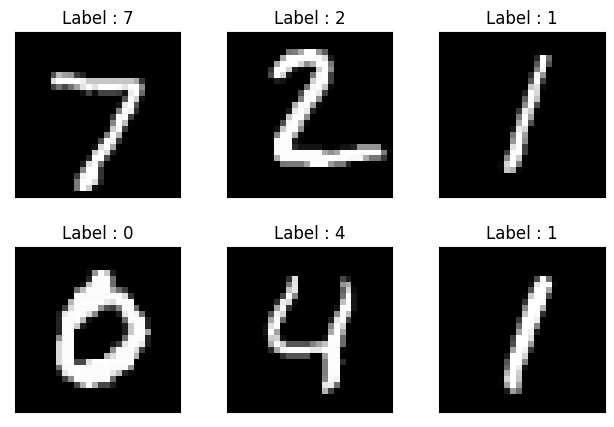

In [9]:
## Affichage de quelques chiffres
ex,lab = next(iter(test_loader))
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(ex[i].view(width,height), cmap='gray', interpolation='none')
  plt.title("Label : {}".format(lab[i]))
  plt.xticks([])
  plt.yticks([])

In [42]:
print(width*height)

784


##  <font color="green"> Premier réseau </font>

Construire un réseau à deux couches avec par exemple 100 neurones dans la couche cachée et une activation tanh. Entraînez le sur une cinquantaine d'époques et visualisez les courbes de coût et de précision. Pour cela, utilisez dans un premier temps une <a href="https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html">**CrossEntropyLoss**</a>.  Lisez bien la documentation : ce coût prend en entrée les prédictions pour chaque classe pour chaque exemple et un vecteur d'entier indiquant les indexes des labels des classes.

In [51]:
netSeqMNIST = torch.nn.Sequential(torch.nn.Linear(784,100),torch.nn.Tanh(),torch.nn.Linear(100,10))
netSeqMNIST.name="mon réseau"
dataloaders={}
dataloaders["train"]=train_loader
dataloaders["test"]=test_loader

In [54]:
losses,acc=train(netSeqMNIST,dataloaders,torch.nn.CrossEntropyLoss(),EPS,EPOCHS,acc=True)

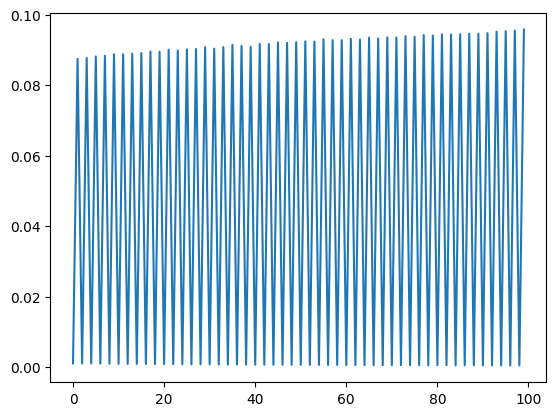

In [56]:
plt.plot(range(0,len(losses)),losses)

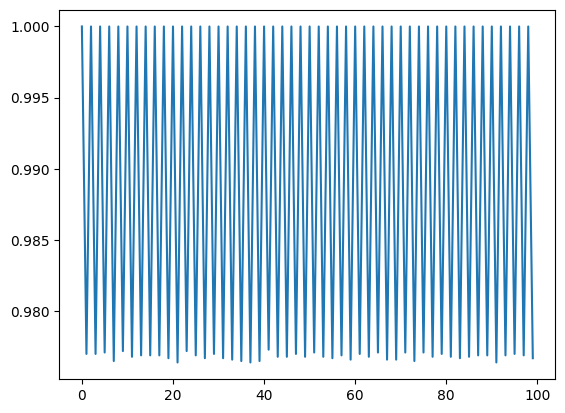

In [57]:
plt.plot(range(0,len(acc)),acc)

Utilisez cette fois une <a href="https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss"> **MSELoss**</a>. Attention, ce coût prend en entrée la prédiction pour chaque clase pour chaque exemple et une cible de même taille ! Vous aurez donc besoin de définir un coût auxiliaire qui prend les mêmes paramètres  que la **CrossEntropyLoss**, qui transforme chaque indexe en vecteur *one hot* et qui applique dessus le coût MSE afin de garder la même boucle d'apprentissage (regardez pour cela <a href="https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html">https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html</a>).

In [58]:
losses,acc=train(netSeqMNIST,dataloaders,torch.nn.MSELoss(),EPS,EPOCHS,acc=True)

/users/nfs/Enseignants/piwowarski/venv/deepdac/lib/python3.9/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (32) at non-singleton dimension 1

## Auto-encoder naïf

Faîtes une classe **AutoEncoder** qui implémente un auto-encodeur : 
* un sous-module **encoder** qui applique une successsion de linéaires et de fonction d'activation, de dimension de plus en plus petite (exemple : DIM_Inx500, 500x100, 100x10)
* un sous-module **decoder** qui applique une succession inverse de linéaires (exemple : 10x100, 100x500, 500xDIM_IN)
* une méthode **forward** qui enchaîne une passe d'encodeur et une passe de décodeur.

Cette classe permet d'*autoencoder* des exemples, c'est-à-dire trouver une représentation plus compacte et sémantiquement informative des exemples. Le réseau est appris sur un coût mesurant la différence entre la sortie du réseau et l'entrée d'origine.

Proposez un dataloader pour apprendre un auto-encodeur. Scalez les sorties entre 0 et 1. Comparez les résultats sur MNIST en étudiant la *Tanh* et la *ReLU*, ainsi qu'un *BCELoss* comparé à un *MSELoss*. Tracez les images décodés durant l'apprentissage (avec **add_images** par exemple de *tensorboard*. 

Vous pouvez également comparer les *embeddings* appris (la couche de sortie de l'encodeur) avec **add_embeddings** de *tensorboard*).